In [1]:
import pandas as pd
import vectorbtpro as vbt
from datetime import datetime, timedelta
import pytz
import numpy as np
import pandas_ta as ta
import logging
from backtesting import Strategy, Backtest
from backtesting.lib import resample_apply
logging.basicConfig(level=logging.WARNING, format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')
import multiprocessing as mp
mp.set_start_method('fork')


/home/htram/onramp/position-management/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Some useful constants - may be extracted later on

In [2]:
OUTPUT_DIR                = "html_files"
OUTPUT_FILE_NAME_PREFIX   = "strat"
OUTPUT_FILE_NAME_PATTERN  = f'{OUTPUT_DIR}/{OUTPUT_FILE_NAME_PREFIX}'
OUTPUT_FILE_EXTENSION     = ".html"

## Some useful utils - may be extracted later on

In [3]:
import os

# This will be handy when we want to plot so it doesn't store all the html files in the root
def create_filename(stats_df):
    # Check if the folder html_files exists, if not create it
    if not os.path.exists(OUTPUT_DIR):
      os.makedirs(OUTPUT_DIR)
    
    filename  = str(OUTPUT_FILE_NAME_PATTERN)
    params    = stats_df._strategy.__dict__['_params']

    # unpack the best params and add them to a filename
    for key, value in params.items():
        # keep the first 5 letters from each key
        key       = key[:5]
        # just keep the first 4 digits from each value
        value     = str(value)[:4]
        filename += f'_{key}_{value}_'

    filename += OUTPUT_FILE_EXTENSION
    
    return filename


In [4]:

start = "2018-01-01"
# Enter your parameters here
metric = 'total_return'

start_date = datetime(2020, 1, 1, tzinfo=pytz.utc)  # time period for analysis, must be timezone-aware
end_date = datetime.now(pytz.utc)
# end_date = datetime(2020, 1, 1, tzinfo=pytz.utc)

# The following is the number of days to look back for the analysis
time_buffer = timedelta(days=100)  # buffer before to pre-calculate SMA/EMA, best to set to max window
freq = '1h'

vbt.settings.portfolio['init_cash'] = 100_000.  # 100,000$
# vbt.settings.portfolio['fees'] = 0.0025  # 0.25%
# vbt.settings.portfolio['slippage'] = 0.0025  # 0.25%

# get binance data doing it this way allows for you to update your data rather than re-downloading it
# binance_data = vbt.BinanceData.fetch(symbols,timeframe=freq, start=start_date,end="now UTC")
# binance_data.save("binance_data.pkl")

# If you already have the data downloaded, you can load it
# binance_data = vbt.BinanceData.load("binance_data.pkl")
# binance_data = binance_data.update() if you want to update it.
#futures_path = '/Users/ericervin/Documents/Coding/data-repository/data/BTCUSDT_1m_futures.pkl'
futures_path = 'test_data/BTCUSDT_1m_futures.pkl'

If you don't have the datafile yet you can grab it from this [link](https://drive.google.com/drive/folders/1jKy2DMbBow-J5jTvPutw-j17m7Ss8R3i?usp=drive_link)

In [5]:
btc = vbt.BinanceData.load(futures_path)
df = btc.get()

In [6]:
df

,Open,High,Low,Close,Volume,Quote volume,Trade count,Taker base volume,Taker quote volume
Open time,,,,,,,,,
2021-01-01 00:00:00+00:00,28948.19,28997.16,28935.30,28991.01,143.661,4.161510e+06,1120,114.439,3.315299e+06
2021-01-01 00:01:00+00:00,28992.98,29045.93,28991.01,29035.18,256.280,7.437731e+06,1967,179.650,5.213713e+06
2021-01-01 00:02:00+00:00,29036.41,29036.97,28993.19,29016.23,102.675,2.979644e+06,987,44.060,1.278719e+06
2021-01-01 00:03:00+00:00,29016.23,29023.87,28995.50,29002.92,85.762,2.487845e+06,832,56.768,1.646753e+06
2021-01-01 00:04:00+00:00,29005.93,29019.98,29000.00,29000.00,70.246,2.037999e+06,752,46.645,1.353346e+06
...,...,...,...,...,...,...,...,...,...
2023-06-03 23:08:00+00:00,27055.50,27058.10,27055.50,27058.10,33.934,9.181214e+05,538,10.977,2.970001e+05
2023-06-03 23:09:00+00:00,27058.10,27060.00,27058.00,27060.00,22.295,6.032967e+05,375,18.930,5.122406e+05
2023-06-03 23:10:00+00:00,27060.00,27060.50,27059.90,27060.50,40.601,1.098664e+06,494,24.383,6.598049e+05


In [7]:
# If you don't already have the data you can download it from Binance
# get binance data doing it this way allows for you to update your data rather than re-downloading it
# binance_data = vbt.BinanceData.fetch(symbols,timeframe=freq, start=start_date,end="now UTC")
# df = binance_data.get()

# Generate Entry Signals
For this I will generate an entry signal every day at midnight. The challenge will be to build a strategy that is able to choose the proper position size for the first and subsequent entries. Then take profit if the trade is quickly profitable and work itself out of a hole if the trade turns against it. I will perform this first on a strategy for long positions, then on short positions. Then we will attempt to see if we can run the strategy for more intelligent entry points. 

In [8]:
# create a signal array the same length as the dataframe
signal = np.zeros(len(df))
signal = pd.Series(signal, index=df.index)
# set the signal to 1 at midnight UTC
signal[df.at_time('00:00').index] = 1
# Create a -1 right before the signal
signal[df.at_time('12:00').index] = -1 # for exiting 1 minute before midnight
df['signal'] = signal
# Convert to int
df['signal'] = df['signal'].astype(int)
df['signal'].sum()

0

In [9]:

short_df = df.loc['2023']

In [10]:
# Create a benchmark strategy class that shows the impact of buying every day at midnight UTC and closing the trade at the end of the day
class Benchmark_Long(Strategy):
    def SIGNAL(self):
        return self.data.signal
    def init(self):
        super().init()
        self.signal = self.I(self.SIGNAL)
    
    def next(self):
        super().next()
        if self.signal == 1:
            self.buy()
        elif self.signal == -1:
            self.position.close()

## Run this if you want to see what a benchmark would be.
Notably if you went long the market every day and closed your position at the end of day, you would only have about a 50% win rate.

In [11]:
# bt = Backtest(short_df, Benchmark_Long, cash=100_000, exclusive_orders=False)
# stats = bt.run()
# stats

Note ~ 50% of the days are positive and 50 are negative. So choosing an up or a down day is totally random. This should help with our testing.

# Create a money management strategy
We will have a quick profit rule, if the market moves in your favor you exit the position with a profit. Else, you fight like hell to manage the postion and end up with a profit.

### Let's also add the decay function
Below is an example of how the decay function will work within our class. 

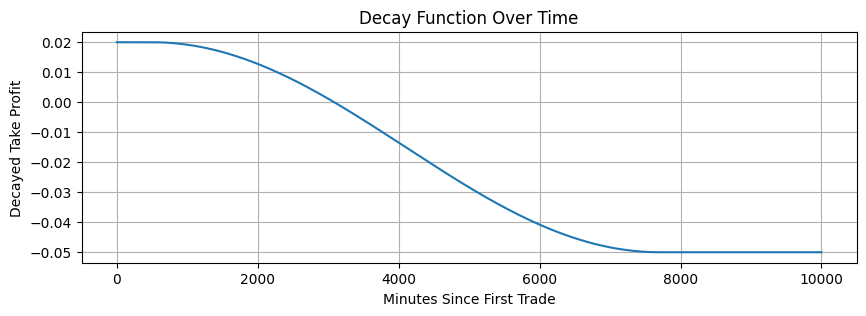

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define the custom decay function
def custom_decay_func(x, delay_period, upper_bound, lower_bound, delta_time):
    if x <= delay_period:
        return upper_bound
    elif delay_period < x < delay_period + delta_time:
        # Calculate the x value for the cos function
        transition_x = (x - delay_period) / delta_time * np.pi
        return (-np.cos(transition_x) + 1) / 2 * (lower_bound - upper_bound) + upper_bound
    else:
        return lower_bound

# Define the parameters
delay_period = 500  # 60 minutes
upper_bound_profit_target = 0.02 # Target Profit
lower_bound_loss_threshold = -0.05 # Worst acceptable loss
delta_time = 60*24*5  # how long the decay period lasts before leveling off

# Create an array of x values from 0 to 5000 minutes
x_values = np.linspace(0, 10000, 5001)

# Calculate the y values
y_values = [custom_decay_func(x, delay_period, upper_bound_profit_target, lower_bound_loss_threshold, delta_time) for x in x_values]

# Create the plot
plt.figure(figsize=(10, 3))
plt.plot(x_values, y_values)
plt.title('Decay Function Over Time')
plt.xlabel('Minutes Since First Trade')
plt.ylabel('Decayed Take Profit')
plt.grid(True)
plt.show()


### Build the strategy

In [13]:
from tqdm.notebook import tqdm


class Underwater_w_decay_and_deleverage(Strategy):
    # All of the following variables can be used during optimization
    initial_position_size = 0.3
    percent_invested_threshold = 0.50
    atr_length = 14  # 14 days
    atr_multiplier = 0.5
    add_size = 0.30
    delay_period = 1000
    delta_time = 5000
    upper_bound_profit_target = 0.10
    lower_bound_loss_threshold = -0.05
    take_profit_loss_reduction = (
        -0.1
    )  # This is the amount that the take profit is reduced by if the position is highly leveraged and we wish to trim
    deleverage_pct = 0.30  # This is the amount that the position is reduced by if the position is highly leveraged and we wish to trim

    def SIGNAL(self):
        return self.data.signal

    def ATR(self, df, length):
        return df.ta.atr(length=length)

    def bars_since_first_trade(self, use_for_indexing=False):
        """
        Calculate the number of bars since the first trade was entered.
        If use for indexing is true then it will return 1 if there are no trades.
        This way you can retrieve the last element of a list by applying a - to the return value.
        eg. self.equity[-self.bars_since_first_trade(use_for_indexing=True):] gives you the array of your account's equity since you entered the first trade that is currently open
        """
        if len(self.trades) > 0 and self.trades[0].is_long:
            self.first_trade_entry_bar = self.trades[0].entry_bar
            bars_since_first_trade = len(self.data.Close) - self.first_trade_entry_bar
            return bars_since_first_trade
        elif use_for_indexing:
            return 1
        else:
            return 0

    def custom_decay_func(
        self,
        x,
        delay_period,
        upper_bound_profit_target,
        lower_bound_loss_threshold,
        delta_time,
    ):
        """
        This function is used to calculate the decayed take profit x represents the number of bars since the first trade was entered
        x is the number of bars since the first trade was entered
        delay_period is the number of bars to wait before starting to decay
        upper_bound_profit_target is the upper bound of the take profit
        lower_bound_loss_threshold is the lower bound of the take profit
        delta_time is the number of bars over which to transition from the upper bound to the lower bound
        """
        if x <= delay_period:
            return upper_bound_profit_target
        elif delay_period < x < delay_period + delta_time:
            # Calculate the x value for the cos function
            transition_x = (x - delay_period) / delta_time * np.pi
            # Calculate the decayed take profit
            return (-np.cos(transition_x) + 1) / 2 * (
                lower_bound_loss_threshold - upper_bound_profit_target
            ) + upper_bound_profit_target
        else:
            return lower_bound_loss_threshold

    def init(self):
        super().init()
        self.signal = self.I(self.SIGNAL)
        self.atr = self.I(self.ATR, self.data.df, self.atr_length)
        self.daily_atr = resample_apply("1D", self.ATR, self.data.df, length=14)
        count_NaN = len(self.atr) - len(
            pd.Series(self.atr).dropna()
        )  # This is used for the progress bar
        self.length_of_data = (
            len(self.data.Close) - count_NaN
        )  # This is used for the progress bar
        self.equity_during_trade = []  # Keeps a list for the equity during the trade

    def next(self):
        super().next()

        price = self.data.Close[-1]
        position_value = self.position.size * price
        percent_invested = (
            position_value / self.equity
        )  # this will come in handy if we decide to change behavior once XX% is invested
        atr_threshold_pct = (
            self.atr_multiplier * self.daily_atr[-1] / price
        )  # This is the ATR threshold times a multiplier calculated as a percentage of price
        bars_since_trade_open = self.bars_since_first_trade(use_for_indexing=True)
        highly_leveraged = percent_invested > self.percent_invested_threshold
        # Calculate the decayed take profit
        decayed_take_profit = self.custom_decay_func(
            bars_since_trade_open,
            self.delay_period,
            self.upper_bound_profit_target,
            self.lower_bound_loss_threshold,
            self.delta_time,
        )

        # Keep a running list of the self.equity values while we have a trade open
        if self.position.size > 0:
            self.equity_during_trade.append(self.equity)
        else:
            self.equity_during_trade = []

        low_point_in_trade = min(self.equity_during_trade, default=0)
        bounce_from_low_pct = (lambda x: (self.equity - x) / x if x != 0 else 0)(
            low_point_in_trade
        )  # The lambda function is used to avoid a divide by zero error

        if self.position.pl_pct > decayed_take_profit:
            self.position.close()

        # Deleverage if we are over a certain percent invested and the market is recovering from the low point
        elif (
            highly_leveraged and bounce_from_low_pct > 1.5 * atr_threshold_pct
        ):  # TODO: maybe make this a parameter we can tune
            # TODO: this is crude but it works for now
            # For now, just trim 20% of the position if we are within 5% of the take profit
            if (
                self.position.pl_pct
                > decayed_take_profit + self.take_profit_loss_reduction
            ):
                self.position.close(portion=self.deleverage_pct)

        elif self.position.size > 0 and self.position.pl_pct < -atr_threshold_pct:
            # Check to see if we are also down on our last trade
            if self.trades[-1].pl_pct < -atr_threshold_pct:
                self.buy(size=self.add_size)

        elif not self.position and self.signal == 1:
            self.buy(size=self.initial_position_size)

### Run the strategy

In [17]:
# start = '2022-05-01' # Note the strategy requires a warmup period for the ATR to calculate first trades begin after 14 days
# end = '2022-12-03' # It will always close any open trades at the end of the backtest
# bt = Backtest(df.loc[start:end], Underwater_w_decay_and_deleverage, cash=100_000_000, exclusive_orders=False, trade_on_close=True, margin=0.5)
# stats = bt.run()
# print(stats)

Start                     2022-05-01 00:00...
End                       2022-12-03 23:59...
Duration                    216 days 23:59:00
Exposure Time [%]                   80.921339
Equity Final [$]                   86961056.5
Equity Peak [$]                   117329691.7
Return [%]                         -13.038943
Buy & Hold Return [%]                -55.1497
Return (Ann.) [%]                  -20.942578
Volatility (Ann.) [%]               43.495359
Sharpe Ratio                         -0.48149
Sortino Ratio                       -0.532658
Calmar Ratio                        -0.506159
Max. Drawdown [%]                  -41.375518
Avg. Drawdown [%]                   -0.840556
Max. Drawdown Duration      110 days 20:43:00
Avg. Drawdown Duration        1 days 09:02:00
# Trades                                  568
Win Rate [%]                        38.556338
Best Trade [%]                      11.887688
Worst Trade [%]                    -24.523222
Avg. Trade [%]                    

### Plot the strategy
Note you can add `resample=False` to see the actual details. This might be heavy on your browser though with anything more than 4-6 months of minute bars. 

In [18]:
# bt.plot()
bt.plot(resample=False)

GridPlot(id='p1721', ...)

## Create an optimization
Note, this will take a while to run depending on how many parameters you want to optimize on.

I'm copying the class down here to remove the progress bars they conflict with the optimizer progress bars

In [19]:
stats, heatmap = bt.optimize(
    # initial_position_size = np.arange(0.3, 0.6, 0.1).tolist(),
    # percent_invested_threshold = 0.7 
    # atr_length = 14 # 14 days
    # atr_multiplier = np.arange(0.6, 0.8, 0.1).tolist(),
    add_size = np.arange(0.10,0.30, 0.10).tolist(),
    # delay_period = 1000
    delta_time = np.arange(1000,5000,1000).tolist(),
    upper_bound_profit_target = np.arange(0.05, 0.10, 0.05).tolist(),
    lower_bound_loss_threshold = np.arange(0.05, -0.10, -0.05).tolist(),
    # take_profit_loss_reduction = -0.1 # This is the amount that the take profit is reduced by if the position is highly leveraged and we wish to trim
    # deleverage_pct = 0.5 # This is the amount that the position is reduced by if the position is highly leveraged and we wish to trim
    
    maximize='Equity Final [$]', # this can be any of the column names from the stats table the output of the backtest
    max_tries=200,
    random_state=0,
    return_heatmap=True)
heatmap.sort_values(ascending=False).iloc[:-5] # print the top 5 parameter sets

Backtest.optimize:  50%|█████     | 4/8 [05:00<02:49, 42.26s/it] 

In [ ]:
# Plot the heatmap
from backtesting.lib import plot_heatmaps
plot_heatmaps(heatmap, agg='mean')


### Rerun the stats for the best strategy
`stats` is a dataframe with the results of the backtest or optimization but also with three objects, 
`_strategy`
`_equity_curve`
`_trades`

we can unpack the _strategy to ge the best params from the optimization and run that specific backtest.

In [ ]:
best_params = stats._strategy.__dict__["_params"] # This will print out all the parameters used for the best backtest

In [ ]:
bt.run(**best_params)

#### Now plot the results of the best strategy from the optimization

In [ ]:

bt.plot(resample=False)

If you want to work on a smaller sample period, just change `start` and `end` 

```python
start = '2021-01-01' # Note the strategy requires a warmup period for the ATR to calculate
end = '2022-3-31' # It will always close any open trades at the end of the backtest
bt = Backtest(df.loc[start:end], Underwater_w_decay_and_deleverage, cash=100_000_000, exclusive_orders=False, trade_on_close=True)
stats = bt.run()
print(stats)
```
If it is a small enough time period (few months or less) then you can run 

```python
bt.plot(resample=False)
```
Then you can see the detail of all the trades. 


In [ ]:
# stats['_equity_curve'] # To see the dataframe with the equity curve and the drawdown information

In [ ]:
# Or you can look at the full list
# stats['_trades']

In [ ]:

# Look at trades resampled on a daily basis
from backtesting.lib import TRADES_AGG
# stats['_trades'].resample('1D', on='ExitTime',
#                           label='right').agg(TRADES_AGG)

# Reverse the strategy for shorting

In [ ]:
from tqdm.notebook import tqdm


class SHORTING_Underwater_w_decay_and_deleverage(Strategy):
    # All of the following variables can be used during optimization
    initial_position_size = 0.3
    percent_invested_threshold = 0.50
    atr_length = 14  # 14 days
    atr_multiplier = 0.5
    add_size = 0.30
    delay_period = 1000
    delta_time = 5000
    upper_bound_profit_target = 0.10
    lower_bound_loss_threshold = -0.05
    take_profit_loss_reduction = (
        -0.1
    )  # This is the amount that the take profit is reduced by if the position is highly leveraged and we wish to trim
    deleverage_pct = 0.30  # This is the amount that the position is reduced by if the position is highly leveraged and we wish to trim

    def SIGNAL(self):
        return self.data.signal

    def ATR(self, df, length):
        return df.ta.atr(length=length)

    def bars_since_first_trade(self, use_for_indexing=False):
        """
        Calculate the number of bars since the first trade was entered.
        If use for indexing is true then it will return 1 if there are no trades.
        This way you can retrieve the last element of a list by applying a - to the return value.
        eg. self.equity[-self.bars_since_first_trade(use_for_indexing=True):] gives you the array of your account's equity since you entered the first trade that is currently open
        """
        if len(self.trades) > 0 and self.trades[0].is_short:
            self.first_trade_entry_bar = self.trades[0].entry_bar
            bars_since_first_trade = len(self.data.Close) - self.first_trade_entry_bar
            return bars_since_first_trade
        elif use_for_indexing:
            return 1
        else:
            return 0

    def custom_decay_func(
        self,
        x,
        delay_period,
        upper_bound_profit_target,
        lower_bound_loss_threshold,
        delta_time,
    ):
        """
        This function is used to calculate the decayed take profit x represents the number of bars since the first trade was entered
        x is the number of bars since the first trade was entered
        delay_period is the number of bars to wait before starting to decay
        upper_bound_profit_target is the upper bound of the take profit
        lower_bound_loss_threshold is the lower bound of the take profit
        delta_time is the number of bars over which to transition from the upper bound to the lower bound
        """
        if x <= delay_period:
            return upper_bound_profit_target
        elif delay_period < x < delay_period + delta_time:
            # Calculate the x value for the cos function
            transition_x = (x - delay_period) / delta_time * np.pi
            # Calculate the decayed take profit
            return (-np.cos(transition_x) + 1) / 2 * (
                lower_bound_loss_threshold - upper_bound_profit_target
            ) + upper_bound_profit_target
        else:
            return lower_bound_loss_threshold

    def init(self):
        super().init()
        self.signal = self.I(self.SIGNAL)
        self.atr = self.I(self.ATR, self.data.df, self.atr_length)
        self.daily_atr = resample_apply("1D", self.ATR, self.data.df, length=14)
        count_NaN = len(self.atr) - len(
            pd.Series(self.atr).dropna()
        )  # This is used for the progress bar
        self.length_of_data = (
            len(self.data.Close) - count_NaN
        )  # This is used for the progress bar
        self.equity_during_trade = []  # Keeps a list for the equity during the trade

    def next(self):
        super().next()

        price = self.data.Close[-1]
        position_value = self.position.size * price
        percent_invested = (
            position_value / self.equity
        )  # this will come in handy if we decide to change behavior once XX% is invested
        atr_threshold_pct = (
            self.atr_multiplier * self.daily_atr[-1] / price
        )  # This is the ATR threshold times a multiplier calculated as a percentage of price
        bars_since_trade_open = self.bars_since_first_trade(use_for_indexing=True)
        highly_leveraged = percent_invested > self.percent_invested_threshold
        # Calculate the decayed take profit
        decayed_take_profit = self.custom_decay_func(
            bars_since_trade_open,
            self.delay_period,
            self.upper_bound_profit_target,
            self.lower_bound_loss_threshold,
            self.delta_time,
        )

        # Keep a running list of the self.equity values while we have a trade open
        if self.position.size < 0:
            self.equity_during_trade.append(self.equity)
        else:
            self.equity_during_trade = []

        low_point_in_trade = min(self.equity_during_trade, default=0)
        bounce_from_low_pct = (lambda x: (self.equity - x) / x if x != 0 else 0)(
            low_point_in_trade
        )  # The lambda function is used to avoid a divide by zero error

        if self.position.pl_pct > decayed_take_profit:
            self.position.close()

        # Deleverage if we are over a certain percent invested and the market is recovering from the low point
        elif (
            highly_leveraged and bounce_from_low_pct > 1.5 * atr_threshold_pct
        ):  # TODO: maybe make this a parameter we can tune
            # TODO: this is crude but it works for now
            # For now, just trim 20% of the position if we are within 5% of the take profit
            if (
                self.position.pl_pct
                > decayed_take_profit + self.take_profit_loss_reduction
            ):
                self.position.close(portion=self.deleverage_pct)

        elif self.position.size < 0 and self.position.pl_pct < -atr_threshold_pct:
            # Check to see if we are also down on our last trade
            if self.trades[-1].pl_pct < -atr_threshold_pct:
                self.sell(size=self.add_size)

        elif not self.position and self.signal == 1:
            self.sell(size=self.initial_position_size)

In [ ]:
# start = '2022-05-01' # Note the strategy requires a warmup period for the ATR to calculate first trades begin after 14 days
# end = '2022-12-03' # It will always close any open trades at the end of the backtest
# bt = Backtest(df.loc[start:end], SHORTING_Underwater_w_decay_and_deleverage, cash=100_000_000, exclusive_orders=False, trade_on_close=True, margin=0.5)
# stats = bt.run()
# print(stats)
# bt.plot(resample=False)

# Strategy combining Long and Short signals
### WIP 
Our signals are 1 at 00:01 every day and -1 at 12:00 every day. If we are not in a trade, then whichever signal comes first it will work it. 
@hoang, if you can read in the lstm buy signals as a 1 and open sell signals as a -1 then I think this will all work right away. We will have to think about duplicated signals but I don't think that is a problem. 

In [ ]:
class LONG_SHORT_Underwater_w_decay_and_deleverage(Strategy):
    # All of the following variables can be used during optimization
    initial_position_size = 0.3
    percent_invested_threshold = 0.3
    atr_length = 14  # 14 days
    atr_multiplier = 0.6
    add_size = 0.1
    delay_period = 1000
    delta_time = 1000
    upper_bound_profit_target = 0.03
    lower_bound_loss_threshold = 0.00
    take_profit_loss_reduction = -0.15 # amount take profit is reduced by if the position is highly leveraged and we wish to trim
    deleverage_pct = 0.30  # This is the amount that the position is reduced by if the position is highly leveraged and we wish to trim
    bounce_multiplier = 1.5  # multiply the ATR Treshold by this amount to get the bounce threshold we are looking to bounce off a low "max pain" point before we reduce our position
    max_loss_threshold = -0.05 # if the position is down this much, and we are fully invested we will reduce our positio
    max_hold_length = None # Number of minutes to hold a position before closing it None if you want to exit naturally
    
    def SIGNAL(self):
        return self.data.signal

    def ATR(self, df, length):
        return df.ta.atr(length=length)

    def bars_since_first_trade(self, use_for_indexing=False):
        """
        Calculate the number of bars since the first trade was entered.
        If use for indexing is true then it will return 1 if there are no trades.
        This way you can retrieve the last element of a list by applying a - to the return value.
        eg. self.equity[-self.bars_since_first_trade(use_for_indexing=True):] gives you the array of your account's equity since you entered the first trade that is currently open
        """
        if len(self.trades) > 0:
            self.first_trade_entry_bar = self.trades[0].entry_bar
            bars_since_first_trade = len(self.data.Close) - self.first_trade_entry_bar
            return bars_since_first_trade
        elif use_for_indexing:
            return 1
        else:
            return 0

    def custom_decay_func(
        self,
        x,
        delay_period,
        upper_bound_profit_target,
        lower_bound_loss_threshold,
        delta_time,
    ):
        """
        This function is used to calculate the decayed take profit x represents the number of bars since the first trade was entered
        x is the number of bars since the first trade was entered
        delay_period is the number of bars to wait before starting to decay
        upper_bound_profit_target is the upper bound of the take profit
        lower_bound_loss_threshold is the lower bound of the take profit
        delta_time is the number of bars over which to transition from the upper bound to the lower bound
        """
        if x <= delay_period:
            return upper_bound_profit_target
        elif delay_period < x < delay_period + delta_time:
            # Calculate the x value for the cos function
            transition_x = (x - delay_period) / delta_time * np.pi
            # Calculate the decayed take profit
            return (-np.cos(transition_x) + 1) / 2 * (
                lower_bound_loss_threshold - upper_bound_profit_target
            ) + upper_bound_profit_target
        else:
            return lower_bound_loss_threshold

    def init(self):
        super().init()
        self.signal = self.I(self.SIGNAL)
        self.atr = self.I(self.ATR, self.data.df, self.atr_length)
        self.daily_atr = resample_apply("1D", self.ATR, self.data.df, length=14)
        count_NaN = len(self.atr) - len(
            pd.Series(self.atr).dropna()
        )  # This is used for the progress bar
        self.length_of_data = (
            len(self.data.Close) - count_NaN
        )  # This is used for the progress bar
        self.equity_during_trade = []  # Keeps a list for the equity during the trade
        self.long_short_flag = (
            None  # This is used to keep track of whether we are long or short
        )
        self.price_at_last_trim = (
            0  # This is used to keep track of the price at the last trim
        )

    def next(self):
        super().next()

        price = self.data.Close[-1]
        position_value = self.position.size * price
        percent_invested = (
            position_value / self.equity
        )  # this will come in handy if we decide to change behavior once XX% is invested
        atr_threshold_pct = (
            self.atr_multiplier * self.daily_atr[-1] / price
        )  # This is the ATR threshold times a multiplier calculated as a percentage of price
        bars_since_trade_open = self.bars_since_first_trade(use_for_indexing=True)
        highly_leveraged = abs(percent_invested) > self.percent_invested_threshold
        # Calculate the decayed take profit
        decayed_take_profit = self.custom_decay_func(
            bars_since_trade_open,
            self.delay_period,
            self.upper_bound_profit_target,
            self.lower_bound_loss_threshold,
            self.delta_time,
        )

        # Calculate the lowest the equity ever got since we have been in a trade
        if self.position:  
            self.lowest_equity_during_trade = min(self.lowest_equity_during_trade, self.equity)
        else:
            self.lowest_equity_during_trade = float('inf')  # Reset to a very high number when not in a position

        low_point_in_trade = min(self.equity_during_trade, default=0)

        # Calculate the percentage bounce from the low point in the trade this is based on equity so works for long or short
        bounce_from_low_pct = (lambda x: (self.equity - x) / x if x != 0 else 0)(
            low_point_in_trade
        )  # The lambda function is used to avoid a divide by zero error

        # Opening a Trade on a signal from the LSTM
        if not self.position:
            if self.signal == 1:
                self.buy(size=self.initial_position_size)
                self.long_short_flag = 1
            elif self.signal == -1:
                self.sell(size=self.initial_position_size)
                self.long_short_flag = -1
        
        # If we are in a short trade and the account is fully invested and the loss is greater than the max loss threshold then close the trade
        if self.long_short_flag == -1 and (abs(percent_invested) > 1 and self.position.pl_pct < self.max_loss_threshold):
            self.position.close() # If you want a partial close add `portion=self.deleverage_pct`
        
        # If we are in a trade and it meets our profit criteria then close the trade
        if self.position.pl_pct > decayed_take_profit:
            self.position.close()
            self.price_at_last_trim = 0
            # print(f'Closing at {price} at {self.data.index[-1]} Position PNL is {self.position.pl}')

        # If we are in a trade and it meets our loss criteria then close a portion of the trade on a bounce from the low point
        if self.position and self.position.pl_pct < -atr_threshold_pct:
            # Check to see if we are also down on our last trade
            if self.trades[-1].pl_pct < -atr_threshold_pct:
                if self.long_short_flag == 1:
                    self.buy(size=self.add_size)
                elif self.long_short_flag == -1:
                    self.sell(size=self.add_size)
        
        # If we are totally upside down then reduce the position size
        if self.position and self.position.pl_pct < decayed_take_profit + self.take_profit_loss_reduction:
            if self.trades[-1].pl_pct < -atr_threshold_pct: # if we are down more than 1 ATR threshold then reduce the position size and take a tiny loss
                self.position.close(portion=self.deleverage_pct)
                # print(f'Closing at {price} at {self.data.index[-1]} Position PNL is {self.position.pl}')
        
        # Deleverage if we are over a certain percent invested and the market is recovering from the low point
        if (
            highly_leveraged
            and bounce_from_low_pct > self.bounce_multiplier * atr_threshold_pct
        ):

            if (self.position.pl_pct > decayed_take_profit + self.take_profit_loss_reduction):
                if (self.long_short_flag == 1) and (self.price_at_last_trim == 0 or price > self.price_at_last_trim *(1 + 2 * atr_threshold_pct)):
                    self.position.close(portion=self.deleverage_pct)
                    # Keep track of the price to avoid trimming too often
                    self.price_at_last_trim = price 
                    # print(f'Deleveraging at {price} at {self.data.index[-1]} Position PNL is {self.position.pl}')
                elif (self.long_short_flag) == -1 and (self.price_at_last_trim == 0 or price < self.price_at_last_trim *(1 - 0.5 * atr_threshold_pct)):
                    self.position.close(portion=self.deleverage_pct)
                    # Keep track of the price to avoid trimming too often
                    self.price_at_last_trim = price 
                    # print(f'Deleveraging at {price} at {self.data.index[-1]} Position PNL is {self.position.pl}')



start = "2022-01-01"  # Note the strategy requires a warmup period for the ATR to calculate first trades begin after 14 days
end = "2023-06-03"  # It will always close any open trades at the end of the backtest
bt = Backtest(
    df.loc[start:end],
    LONG_SHORT_Underwater_w_decay_and_deleverage,
    cash=100_000_000,
    exclusive_orders=False,
    trade_on_close=True,
    margin=1,
)
stats = bt.run()
filename = create_filename(stats)
print(stats)
bt.plot(resample=False, filename=filename)

Start                     2022-01-01 00:00...
End                       2023-06-03 23:12...
Duration                    518 days 23:12:00
Exposure Time [%]                   88.114752
Equity Final [$]                 119061196.26
Equity Peak [$]                  140469459.76
Return [%]                          19.061196
Buy & Hold Return [%]              -41.491126
Return (Ann.) [%]                   13.054371
Volatility (Ann.) [%]               27.710857
Sharpe Ratio                         0.471092
Sortino Ratio                        0.719683
Calmar Ratio                         0.524007
Max. Drawdown [%]                  -24.912575
Avg. Drawdown [%]                   -0.346189
Max. Drawdown Duration      151 days 07:32:00
Avg. Drawdown Duration        0 days 19:59:00
# Trades                                  561
Win Rate [%]                        40.463458
Best Trade [%]                      17.849438
Worst Trade [%]                    -50.147708
Avg. Trade [%]                    

GridPlot(id='p3118', ...)

## Now let's optimize the long short strategy
Note, this will take a while to run depending on how many parameters you want to optimize on.

I'm copying the class down here to remove the progress bars they conflict with the optimizer progress bars

In [ ]:
stats, heatmap = bt.optimize(
    # initial_position_size = np.arange(0.3, 0.6, 0.1).tolist(),
    # percent_invested_threshold = 0.7 
    # atr_length = np.arange(7,37,10).to_list(), # 14 days
    # atr_multiplier = np.arange(0.6, 0.8, 0.1).tolist(),
    add_size = np.arange(0.10,0.30, 0.10).tolist(),
    # delay_period = np.arange(250,1500,500).tolist(),
    delta_time = np.arange(1000,5000,1000).tolist(),
    upper_bound_profit_target = np.arange(0.05, 0.10, 0.05).tolist(),
    lower_bound_loss_threshold = np.arange(0.05, -0.10, -0.05).tolist(),
    take_profit_loss_reduction = np.arange(-0.15, -0.05, 0.05).tolist(), # This is the amount that the take profit is reduced by if the position is highly leveraged and we wish to trim
    # deleverage_pct = 0.5 # This is the amount that the position is reduced by if the position is highly leveraged and we wish to trim
    
    maximize='Equity Final [$]', # this can be any of the column names from the stats table the output of the backtest
    max_tries=200,
    random_state=0,
    return_heatmap=True)
best_params = stats._strategy.__dict__["_params"] # This will print out all the parameters used for the best backtest
print(f'Best Parameters: {best_params}')
heatmap.sort_values(ascending=False).iloc[:-5] # print the top 5 parameter sets

Backtest.optimize:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
# Plot the heatmap
from backtesting.lib import plot_heatmaps
plot_heatmaps(heatmap, agg='mean')


### Rerun the stats for the best strategy


In [ ]:
bt.run(**best_params)
bt.plot(resample=False)

# Thoughts for additional improvements
- add a percent_of_equity method that would take total risk into account.
- perhaps reduce risk when leverage is high and we are recovering from a big underwater period.
- Consider a dynamic take profit target and lower loss limit ie. (2*ATR for upper) and (-3*ATR for lower)
- Weekly or monthly PnL targets to reduce quantity of time we are in market

# Add in our signals
Run the strategies long and short based on our own AI buy and sell signals. Use it as an opportunity to improve the results of our existing AI models.
#### Read in a dataframe of our signals
prep the dataframe so it has the `Close` price, the `signal` column. 
For this we can create an `entries` column and an `exits` column.

| trigger (from CSV)  | entries          | exits            | signal |
| --------            | --------         | --------         | --     |
| 1 day passed        | None             | 1 day passed     | 0      |
| lstm_open-long      | lstm_open-long   | None             | 1      |
| lstm_open-short     | lstm_open-short  | None             | -1     |
| NA                  | None             | None             | 0      |
| stop loss           | None             | stop loss        | 0      |
| take profit         | None             | take profit      | 0      |

                      

We can then tweak our code above to read from the `entries` column instead of the `signal` column. We will be ignoring the LSTM exits for now because the backtest strategy takes over once we are in a trade. Perhaps this is something we will change in the future but for now we can keep it as is.


# Import the trades dataframe and manipulate it.

## Step 1 - Read in the CSV files

In [ ]:
from typing import List
lstm_csv_files = ["test_data/2dc0f4b2_minutely.csv",
"test_data/3dca0a12_minutely.csv",
"test_data/9295144c_minutely.csv",
"test_data/b2d47ab1_minutely.csv",
"test_data/b9962cd1_minutely.csv"]

def _read_lstm_files() -> List:
  lstm_dfs = []

  for file in lstm_csv_files:
    lstm_dfs.append(pd.read_csv(file))

  return lstm_dfs
    

## Define constants and mappings

In [ ]:
from dataclasses import dataclass
from typing import Optional
from collections import defaultdict

@dataclass
class BackTestColumnValues:
  entries : Optional[str]
  exits   : Optional[str]
  signal  : int

LSTM_TRIGGER_MAP = defaultdict(
  lambda            : BackTestColumnValues(None             , None            , 0 ), 
{
  "1 day passed"    : BackTestColumnValues(None             , "1 day passed"  , 0 ),
  "lstm_open-long"  : BackTestColumnValues("lstm_open-long" , None            , 1 ),
  "lstm_open-short" : BackTestColumnValues("lstm_open-short", None            , -1),  
  "N/A"             : BackTestColumnValues(None             , None            , 0 ),
  "stop loss"       : BackTestColumnValues(None             , "stop loss"     , 0 ),
  "take profit"     : BackTestColumnValues(None             , "take profile"  , 0 ),
})



## Define the transformation 

In [ ]:
def _map_lstm_trigger_to_signal(trigger: str) -> Optional[int]:
  return LSTM_TRIGGER_MAP[trigger].signal


def _map_lstm_trigger_to_entries(trigger: str) -> Optional[str]:
  return LSTM_TRIGGER_MAP[trigger].entries


def _map_lstm_trigger_to_exits(trigger: str) -> Optional[str]:
  return LSTM_TRIGGER_MAP[trigger].exits


def _transform_lstm_dfs(lstm_dfs: List):
  for lstm_df in lstm_dfs:    
    lstm_df.rename(columns={'price': 'Close'}, inplace=True)

    lstm_df['trigger']  = lstm_df['trigger'].astype(str)
    lstm_df['entries']  = lstm_df['trigger'].apply(_map_lstm_trigger_to_entries)
    lstm_df['exits']    = lstm_df['trigger'].apply(_map_lstm_trigger_to_exits)
    lstm_df['signal']   = lstm_df['trigger'].apply(_map_lstm_trigger_to_signal)    
    lstm_df['time']     = pd.to_datetime(lstm_df['time'], unit='s').dt.strftime('%Y-%m-%dT%H:%M:%S.%fZ')

## The starting point of backtesting LSTM CSV files

In [ ]:
lstm_dfs = _read_lstm_files()
_transform_lstm_dfs(lstm_dfs)

Need to make a slight mod to our filename func

In [ ]:
# This will be handy when we want to plot so it doesn't store all the html files in the root
def create_filename(stats_df):
    params = stats_df._strategy.__dict__['_params']
    filename = 'html_files/strat'
    # unpack the best params and add them to a filename
    for key, value in params.items():
        # keep the first 5 letters from each key
        key = key[:5]
        # just keep the first 4 digits from each value
        value= str(value)[:4]
        filename += f'_{key}_{value}_'
    # filename += '.html'
    return filename

In [ ]:
test_df = lstm_dfs[0]
# Rename open, high, low, close to Open, High, Low, Close
test_df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)
test_df.sort_index(inplace=True)
test_df

,time,trigger,Close,Open,High,Low,entries,exits,signal
time,,,,,,,,,
2021-01-09 00:01:00+00:00,2021-01-09T00:01:00.000000Z,nan,40667.33,40638.91,40720.14,40638.90,None,None,0
2021-01-09 00:02:00+00:00,2021-01-09T00:02:00.000000Z,nan,40722.11,40661.11,40783.61,40640.00,None,None,0
2021-01-09 00:03:00+00:00,2021-01-09T00:03:00.000000Z,nan,40873.86,40718.03,40873.86,40706.89,None,None,0
2021-01-09 00:04:00+00:00,2021-01-09T00:04:00.000000Z,nan,40921.72,40873.86,40955.50,40840.50,None,None,0
2021-01-09 00:05:00+00:00,2021-01-09T00:05:00.000000Z,nan,40954.88,40927.10,40988.63,40913.35,None,None,0
...,...,...,...,...,...,...,...,...,...
2023-05-10 23:02:00+00:00,2023-05-10T23:02:00.000000Z,nan,27678.90,27679.70,27688.00,27672.80,None,None,0
2023-05-10 23:03:00+00:00,2023-05-10T23:03:00.000000Z,nan,27682.90,27678.90,27691.00,27678.90,None,None,0
2023-05-10 23:04:00+00:00,2023-05-10T23:04:00.000000Z,nan,27683.70,27682.90,27686.00,27673.40,None,None,0


In [ ]:
stats_list = []
for i in range(len(lstm_dfs)):
    test_df = lstm_dfs[i]
    test_df.index = pd.to_datetime(test_df['time']) 
    test_df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)
    start = "2022-01-09"  # Note the strategy requires a warmup period for the ATR to calculate first trades begin after 14 days
    end = "2023-05-10"  # It will always close any open trades at the end of the backtest
    bt = Backtest(
        test_df.loc[start:end],
        LONG_SHORT_Underwater_w_decay_and_deleverage,
        cash=100_000_000,
        exclusive_orders=False,
        trade_on_close=True,
        margin=1,
    )
    stats = bt.run()
    stats_list.append(stats)
    filename = create_filename(stats)
    print(stats)
    bt.plot(resample=False, filename=f'{filename}_lstm_{i}.html')
    

/var/folders/dt/m1bsm13n187d7m0ssssp79ww0000gn/T/ipykernel_92974/1982906418.py:8: UserWarning: Data index is not sorted in ascending order. Sorting.
  bt = Backtest(


Start                     2022-01-09 00:00...
End                       2023-05-10 23:06...
Duration                    486 days 23:06:00
Exposure Time [%]                   95.696116
Equity Final [$]                  74432559.17
Equity Peak [$]                  101265872.33
Return [%]                         -25.567441
Buy & Hold Return [%]               -33.63278
Return (Ann.) [%]                  -19.852857
Volatility (Ann.) [%]               20.445416
Sharpe Ratio                        -0.971018
Sortino Ratio                       -1.023566
Calmar Ratio                        -0.646172
Max. Drawdown [%]                  -30.723811
Avg. Drawdown [%]                   -1.460412
Max. Drawdown Duration      461 days 10:34:00
Avg. Drawdown Duration       17 days 09:43:00
# Trades                                  462
Win Rate [%]                        32.034632
Best Trade [%]                      15.663772
Worst Trade [%]                    -53.638019
Avg. Trade [%]                    

/var/folders/dt/m1bsm13n187d7m0ssssp79ww0000gn/T/ipykernel_92974/1982906418.py:8: UserWarning: Data index is not sorted in ascending order. Sorting.
  bt = Backtest(


Start                     2022-01-09 00:00...
End                       2023-05-10 22:44...
Duration                    486 days 22:44:00
Exposure Time [%]                   93.288553
Equity Final [$]                 131637667.06
Equity Peak [$]                  166844980.36
Return [%]                          31.637667
Buy & Hold Return [%]              -33.882012
Return (Ann.) [%]                   22.877919
Volatility (Ann.) [%]               29.240466
Sharpe Ratio                         0.782406
Sortino Ratio                        1.493378
Calmar Ratio                         0.868845
Max. Drawdown [%]                  -26.331421
Avg. Drawdown [%]                   -0.389027
Max. Drawdown Duration      182 days 00:36:00
Avg. Drawdown Duration        0 days 19:52:00
# Trades                                  455
Win Rate [%]                        44.615385
Best Trade [%]                      13.575347
Worst Trade [%]                    -55.875245
Avg. Trade [%]                    

/var/folders/dt/m1bsm13n187d7m0ssssp79ww0000gn/T/ipykernel_92974/1982906418.py:8: UserWarning: Data index is not sorted in ascending order. Sorting.
  bt = Backtest(


Start                     2022-01-09 00:00...
End                       2023-05-10 23:32...
Duration                    486 days 23:32:00
Exposure Time [%]                   95.407364
Equity Final [$]                  85330629.52
Equity Peak [$]                  109351025.02
Return [%]                          -14.66937
Buy & Hold Return [%]              -33.840753
Return (Ann.) [%]                  -11.209995
Volatility (Ann.) [%]               22.672516
Sharpe Ratio                        -0.494431
Sortino Ratio                       -0.589542
Calmar Ratio                        -0.436068
Max. Drawdown [%]                  -25.706965
Avg. Drawdown [%]                    -0.71547
Max. Drawdown Duration      285 days 23:50:00
Avg. Drawdown Duration        4 days 04:38:00
# Trades                                  458
Win Rate [%]                        37.336245
Best Trade [%]                      21.765107
Worst Trade [%]                    -53.457326
Avg. Trade [%]                    

/var/folders/dt/m1bsm13n187d7m0ssssp79ww0000gn/T/ipykernel_92974/1982906418.py:8: UserWarning: Data index is not sorted in ascending order. Sorting.
  bt = Backtest(


Start                     2022-01-09 00:00...
End                       2023-05-10 21:50...
Duration                    486 days 21:50:00
Exposure Time [%]                   94.643664
Equity Final [$]                  76537601.38
Equity Peak [$]                  104526239.98
Return [%]                         -23.462399
Buy & Hold Return [%]              -33.993794
Return (Ann.) [%]                  -18.159976
Volatility (Ann.) [%]               20.038167
Sharpe Ratio                        -0.906269
Sortino Ratio                       -0.998124
Calmar Ratio                        -0.556552
Max. Drawdown [%]                  -32.629436
Avg. Drawdown [%]                   -0.728146
Max. Drawdown Duration      440 days 16:04:00
Avg. Drawdown Duration        6 days 16:03:00
# Trades                                  529
Win Rate [%]                        30.245747
Best Trade [%]                      14.960372
Worst Trade [%]                    -58.432222
Avg. Trade [%]                    

/var/folders/dt/m1bsm13n187d7m0ssssp79ww0000gn/T/ipykernel_92974/1982906418.py:8: UserWarning: Data index is not sorted in ascending order. Sorting.
  bt = Backtest(


Start                     2022-01-09 00:00...
End                       2023-05-10 23:32...
Duration                    486 days 23:32:00
Exposure Time [%]                    93.29928
Equity Final [$]                 128700632.77
Equity Peak [$]                  165201803.67
Return [%]                          28.700633
Buy & Hold Return [%]              -33.840753
Return (Ann.) [%]                   20.817337
Volatility (Ann.) [%]                30.94416
Sharpe Ratio                         0.672739
Sortino Ratio                        1.181409
Calmar Ratio                          0.81698
Max. Drawdown [%]                  -25.480854
Avg. Drawdown [%]                   -0.349445
Max. Drawdown Duration      120 days 09:54:00
Avg. Drawdown Duration        0 days 16:54:00
# Trades                                  441
Win Rate [%]                        46.485261
Best Trade [%]                      17.787887
Worst Trade [%]                    -55.794834
Avg. Trade [%]                    

In [ ]:
# Concatenate all the stats into one dataframe. They are all currently series, I want them all to use the same index
stats_df = pd.concat(stats_list, axis=1)
stats_df

,0,1,2,3,4
Start,2022-01-09 00:00:00+00:00,2022-01-09 00:00:00+00:00,2022-01-09 00:00:00+00:00,2022-01-09 00:00:00+00:00,2022-01-09 00:00:00+00:00
End,2023-05-10 23:06:00+00:00,2023-05-10 22:44:00+00:00,2023-05-10 23:32:00+00:00,2023-05-10 21:50:00+00:00,2023-05-10 23:32:00+00:00
Duration,486 days 23:06:00,486 days 22:44:00,486 days 23:32:00,486 days 21:50:00,486 days 23:32:00
Exposure Time [%],95.696116,93.288553,95.407364,94.643664,93.29928
Equity Final [$],74432559.17,131637667.06,85330629.52,76537601.38,128700632.77
Equity Peak [$],101265872.33,166844980.36,109351025.02,104526239.98,165201803.67
Return [%],-25.567441,31.637667,-14.66937,-23.462399,28.700633
Buy & Hold Return [%],-33.63278,-33.882012,-33.840753,-33.993794,-33.840753
Return (Ann.) [%],-19.852857,22.877919,-11.209995,-18.159976,20.817337
Volatility (Ann.) [%],20.445416,29.240466,22.672516,20.038167,30.94416


Looks like 1 and 4 are best.

In [ ]:
# Save the dataframe to a csv after appending `lstm` as a prefix to each column name
stats_df.columns = [f'lstm_{col}' for col in stats_df.columns]
stats_df.to_csv('lstm_stats.csv')

# Run the backtest on the lstm entries from a single dataframe
Based on looking at the stats 1 and 4 had the best results and were fairly similar. I'm going to run this on 1. You can choose to optimize it on any of them.

In [ ]:
test_df = lstm_dfs[1] # <-- Change this to the index of the dataframe 0,1,2,3,4 you want to plot
test_df.index = pd.to_datetime(test_df['time']) 
test_df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)
test_df.sort_index(inplace=True)

In [ ]:
start = "2021-01-09"  # Note the strategy requires a warmup period for the ATR to calculate first trades begin after 14 days
end = "2023-05-10"  # It will always close any open trades at the end of the backtest
bt = Backtest(
    test_df.loc[start:end],
    LONG_SHORT_Underwater_w_decay_and_deleverage,
    cash=100_000_000,
    exclusive_orders=False,
    trade_on_close=True,
    margin=1,
)
stats = bt.run()
filename = create_filename(stats)
print(stats)
bt.plot(resample=False, filename=filename)

Start                     2021-01-09 00:01...
End                       2023-05-10 22:44...
Duration                    851 days 22:43:00
Exposure Time [%]                   96.412059
Equity Final [$]                 142488500.79
Equity Peak [$]                  180574139.99
Return [%]                          42.488501
Buy & Hold Return [%]              -32.222499
Return (Ann.) [%]                   16.380402
Volatility (Ann.) [%]               32.586697
Sharpe Ratio                         0.502671
Sortino Ratio                        0.906881
Calmar Ratio                         0.533471
Max. Drawdown [%]                  -30.705304
Avg. Drawdown [%]                   -0.500057
Max. Drawdown Duration      296 days 14:49:00
Avg. Drawdown Duration        1 days 07:59:00
# Trades                                 1031
Win Rate [%]                        40.252182
Best Trade [%]                      21.473738
Worst Trade [%]                    -77.415244
Avg. Trade [%]                    

GridPlot(id='p29646', ...)

# Optimize the parameters

In [ ]:
stats, heatmap = bt.optimize(
    # initial_position_size = np.arange(0.3, 0.6, 0.1).tolist(),
    percent_invested_threshold = np.arange(0.3, 0.8, 0.1).tolist(),
    # atr_length = np.arange(7,37,10).to_list(), # 14 days
    atr_multiplier = np.arange(0.3, 1.5, 0.3).tolist(),
    # add_size = np.arange(0.10,0.30, 0.10).tolist(),
    # delay_period = np.arange(250,1500,500).tolist(),
    # delta_time = np.arange(1000,5000,1000).tolist(),
    upper_bound_profit_target = np.arange(0.01, 0.10, 0.02).tolist(),
    # lower_bound_loss_threshold = np.arange(-0.10, 0.03, 0.03).tolist(),
    # take_profit_loss_reduction = np.arange(-0.15, -0.05, 0.05).tolist(), # This is the amount that the take profit is reduced by if the position is highly leveraged and we wish to trim
    # deleverage_pct = 0.5 # This is the amount that the position is reduced by if the position is highly leveraged and we wish to trim
    max_loss_threshold = np.arange(-0.05, -0.20, -0.05).tolist(),
    # maximize='Equity Final [$]', 
    # maximize='Max. Drawdown [%]',# this can be any of the column names from the stats table the output of the backtest
    maximize='Win Rate [%]',
    max_tries=200,
    random_state=0,
    return_heatmap=True)
best_params = stats._strategy.__dict__["_params"] # This will print out all the parameters used for the best backtest
print(f'Best Parameters: {best_params}')
heatmap.sort_values(ascending=False).iloc[:-5] # print the top 5 parameter sets

Backtest.optimize:   0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
stats

Start                     2021-01-09 00:01...
End                       2022-05-15 00:00...
Duration                    490 days 23:59:00
Exposure Time [%]                   75.326856
Equity Final [$]                 118110396.13
Equity Peak [$]                  124512073.56
Return [%]                          18.110396
Buy & Hold Return [%]              -26.034485
Return (Ann.) [%]                   13.143181
Volatility (Ann.) [%]               26.359878
Sharpe Ratio                         0.498606
Sortino Ratio                        0.857617
Calmar Ratio                          0.58005
Max. Drawdown [%]                  -22.658724
Avg. Drawdown [%]                   -0.503644
Max. Drawdown Duration      232 days 10:57:00
Avg. Drawdown Duration        1 days 17:53:00
# Trades                                 1037
Win Rate [%]                        73.866924
Best Trade [%]                      15.821343
Worst Trade [%]                    -50.167386
Avg. Trade [%]                    

In [ ]:
bt.run(**best_params)
bt.plot(resample=False, filename=f'{filename}_optimized.html')

GridPlot(id='p22047', ...)

# Test on different periods of time Possibly set up a cross validation
Nice youtube video here https://www.youtube.com/watch?v=9m987swadQU&t=2154s&ab_channel=ChadThackray